In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

#editing now 
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from   torch.autograd import Variable
import numpy as np
import random
import re

In [0]:
alphabet = "آ‎ا‎ب‎پ‎ت‎ث‎ج‎چ‎ح‎خ‎د‎ذ‎ر‎ز‎ژ‎س‎ش‎ص‎ض‎ط‎ظ‎ع‎غ‎ف‎ق‎ک‎گ‎ل‎م‎ن‎و‎ه‎ی‎*‎ ‎\n‎"
dataset = open('/content/gdrive/My Drive/FINAL CODE/FINAL CODE/data/valid.txt',"r",encoding = 'utf-8').read()


In [0]:

all_words = re.split(' |\n',dataset)
dataset_len = len(all_words)
#print((all_words))

In [0]:
#reading data files 

word_to_idx = {}

k = 0
for word in all_words:
  
  if word not in word_to_idx.keys():
    word_to_idx[word] = k
    k += 1

max_value = max(word_to_idx.values())
#print(word_to_idx["*"])


In [0]:
train_len = 48
batch_size  = 1
num_of_classes = max_value + 1
lstm_in_size = 256
lstm_num_layers = 1
lstm_out_size    = 256
input_size = max_value + 1
output_size = max_value + 1
dropout = 0.2
clip = 0.5

In [0]:


seq_len = dataset_len//batch_size
print("len of dataset : ",dataset_len)
print("seq len : ",seq_len)
max_value = max(word_to_idx.values())
print(max_value)
#print(all_words)

len of dataset :  157332
seq len :  157332
7852


In [0]:
vtensor = autograd.Variable(torch.zeros(seq_len,batch_size,requires_grad = True)).cuda()
vtensor = vtensor.long()
#print(vtensor.type())

In [0]:


print(vtensor.size())

i = 0
j = 0
#for k in word_to_idx.values():
for word in all_words:
    index = word_to_idx[word]
    vtensor[i][j] = index
    j = j+1
    if j == batch_size :
        j = 0
        i = i + 1
    if i == seq_len:
        break
            

print("data set tensor size : ",vtensor.size())
print("number of letters : ",len(alphabet)/2)
print("len of the dataset : ",dataset_len)
#print(vtensor[1][56])


#print(word_to_idx)   
print(dataset_len)
#print(vtensor)

torch.Size([157332, 1])
data set tensor size :  torch.Size([157332, 1])
number of letters :  36.0
len of the dataset :  157332
157332


In [0]:
#torch.save(vtensor,"vtensor_word.pt")

In [0]:
#vtensor = torch.load("vtensor_word.pt")

In [0]:
#define the network 
class LSTM_Network(nn.Module):
    def __init__(self,input_size,lstm_in_size,lstm_out_size,output_size,lstm_num_layers,batch_size):
        
        super(LSTM_Network, self).__init__()
        self.lstm_in_size = lstm_in_size
        self.lstm_out_size = lstm_out_size
        self.batch_size  = batch_size
        self.lstm_num_layers = lstm_num_layers
    
        self.i2lstm = nn.Embedding(input_size,lstm_in_size)
        self.lstm = nn.LSTM(lstm_in_size,lstm_out_size,lstm_num_layers)
        self.dropout = nn.Dropout(dropout)
        self.h2o = nn.Linear(lstm_out_size,output_size)
        
        self.softmax = nn.LogSoftmax(dim = 2)
        
    def init_hidden(self):
        
        return (torch.zeros(self.lstm_num_layers,self.batch_size, self.lstm_out_size).cuda(),
                torch.zeros(self.lstm_num_layers,self.batch_size, self.lstm_out_size).cuda())
    
    def forward(self ,sequence,hidden):
        
        
        first_line = self.i2lstm(sequence)
        out_lstm , hidden = self.lstm(first_line.view(sequence.size(0),batch_size,lstm_in_size),hidden)
        output = self.h2o(out_lstm )
        output = F.relu(output)
        droped_out = self.dropout(output)
        soft_output = self.softmax(droped_out)
        
        return soft_output , hidden

In [0]:
def choosetrainingset(in_tensor,step,start_position):
    #start = random.randint(0,seq_len-1)
    #start = step * pack_num
    if start_position + step < seq_len:            
        final = start_position + step 
    else :
        final =  seq_len 
    
    out_tensor = Variable(torch.empty(final - start_position,batch_size,requires_grad = True)).cuda()
    target = Variable(torch.empty(final - start_position,batch_size,requires_grad = True)).cuda()
    target = target.long()

    for i in range(target.size(0)):
        for j in range(batch_size):
            if( j == batch_size - 1):
                try:
                    target[i][j] = in_tensor[start_position + i + 1][0]
                except:
                    target[i][j] = vtensor[0][0]
                    return in_tensor[start_position:final], target
            else:
                target[i][j] = in_tensor[start_position + i][j + 1]
    out_tensor = in_tensor[start_position:final]
       
    return out_tensor, target 


In [0]:
#defining the model , loss function and optimizer
learning_rate = 0.001
#loss_func = nn.CrossEntropyLoss()
network = LSTM_Network(input_size,lstm_in_size,lstm_out_size,output_size,lstm_num_layers,batch_size).cuda()
loss_func = nn.NLLLoss()

optimizer = optim.SGD(network.parameters(),lr = learning_rate,momentum = 0.9)
#optimizer  = optim.Adam(network.parameters(),lr = learning_rate)

In [0]:
def train(in_tensor,target):

    target_idx = autograd.Variable(torch.empty((target.size(0),target.size(1)),dtype = torch.long )).cuda()
   
    optimizer.zero_grad()
    network.train()
    loss = 0
    
    hidden = network.init_hidden()

    network_output ,hidden =  network(in_tensor,hidden)

    network_output = network_output[ :,-1,: ]

    loss = loss_func(network_output,target.view(-1))
    
    loss.backward()

    torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
    optimizer.step()

 
        
    return network_output, loss.item() / in_tensor.size(0)

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
n_iters = 1000000
print_every = 10000
plot_every = 1000
all_losses = []
total_loss = 0 # Reset every plot_every iters
start = time.time()


In [0]:
output = autograd.Variable(torch.FloatTensor((seq_len,batch_size,num_of_classes)), requires_grad=True)
start_p = 0
for iter in range(1, n_iters + 1):
    out_tensor,target_tensor = choosetrainingset(vtensor,train_len,start_p)#,iter - 1)
    start_p = start_p + train_len
    if(start_p >= seq_len):
        start_p = random.randint(0,seq_len-train_len - 1)
        #train_len = round(train_len * 1.6)
    #print(start)
    output, loss = train(out_tensor,target_tensor)
    #output, loss = train(itensor)
    print(output.size(),"in train","iter =", iter ,"start position =",start_p,end = '\r') 
    total_loss += loss  
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

197m 29s (10000 1%) 0.1155


KeyboardInterrupt: ignored

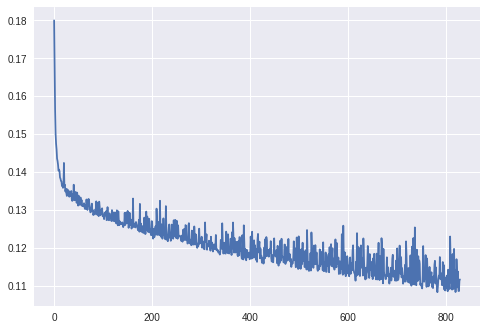

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.figure()
plt.plot(all_losses)

In [0]:
#save the model 
torch.save(network.state_dict(), "/content/gdrive/My Drive/FINAL CODE/FINAL CODE/colab_run_word_final_10.pth")

In [0]:
#load the model
network = LSTM_Network(input_size,lstm_in_size,lstm_out_size,output_size,lstm_num_layers,batch_size).cuda()
network.load_state_dict(torch.load("/content/gdrive/My Drive/FINAL CODE/FINAL CODE/colab_run_word_final_7.pth"))
network.eval()

LSTM_Network(
  (i2lstm): Embedding(7853, 128)
  (lstm): LSTM(128, 128, num_layers=2)
  (dropout): Dropout(p=0.2)
  (h2o): Linear(in_features=128, out_features=7853, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
#start genrating from the network 
maxv = 300
def gen_method_1(start_words):
    
    start_vector = torch.zeros(1,batch_size,dtype=torch.float64).cuda()
    start_vector = start_vector.long()
    
    index = 0
    k = 0
    for i in start_words:
        index = word_to_idx[i]
        print(index)
        start_vector[0][k] = index
        k += 1
        print(start_vector)
   # print(start_vector[0][0])
    poem = list(start_words)
    #print(poem[0])
   # poem
    with torch.no_grad():
        
        hidden = network.init_hidden()
        #out_poem = start_string
        for i in range(maxv):
            #start_vector = torch.randn(1,batch_size,num_of_classes)
            output , hidden = network(start_vector,hidden)
            #print(output.size())
            for j in range(batch_size):
                topv , topi = output[0][j].topk(1)
                #print(topi[0].item())
                top = random.randint(0,num_of_classes-1)
                #print(top,"jj")
                start_vector[0][j] = 0
                start_vector[0][j] = topi
               # print(start_vector)
               # print(start_vector)
                
                for key, value in word_to_idx.items():
                    if value == topi:
                        word = " " + key 
                        poem[j-1] += word
                        word = ""
                
    
              #  start_string[0][j] += letter
               # poem += fa
               
    
                   
    return poem

In [0]:
#start genrating from the network 

def gen_method_2(start_words):
  
    start_len = len(start_words)
    
    start_vector = torch.zeros(start_len,batch_size,dtype=torch.long).cuda()
    
    index = 0
    k = 0
    for i in start_words:
        index = word_to_idx[i]
        #print(index)
        start_vector[k][0] = index
        k += 1
        #print(start_vector)
   # print(start_vector[0][0])
    poem = list(start_words)
    #print(poem[0])
   # poem
    with torch.no_grad():
        
        
        #out_poem = start_string
        
        for i in range(start_len):
            hidden = network.init_hidden()
            #start_vector = torch.randn(1,batch_size,num_of_classes)
            #print(output.size())
            for j in range(maxv):
                output , hidden = network(start_vector[i],hidden)
                topv , topi = output.topk(1)
                #print(topi[0].item())
                #top = random.randint(0,num_of_classes-1)
                #print(top,"jj")
                start_vector[i][0] = 0
                start_vector[i][0] = topi
               # print(start_vector)
               # print(start_vector)
                
                for key, value in word_to_idx.items():
                    if value == topi:
                        word = " " + key 
                        poem[i] += word
                        word = ""
                
    
              #  start_string[0][j] += letter
               # poem += fa
               
    
                   
    return poem

In [0]:

#in_seq = "نام خداوند جان و خرد کزین برتر اندیشه بر نگذرد خداوند نام و خداوند جاى خداوند روزیده رهنماى خداوند كيوان و گردان سپهر فروزنده ماه و ناهيد و مهر ز نام ز نام خداوند جان و خرد کزین برتر اندیشه بر نگذرد خداوند نام و خداوند جاى خداوند روزیده رهنماى خداوند كيوان و گردان سپهر فروزنده ماه و ناهيد و مهر ز نام ز"
in_seq = "به"
start_words = in_seq.split()
print(len(start_words))
gen_method_2(start_words)


1


['به پيش او شد ز گفتار اوى * ز هر سو بر آمد ز جاى نشست ; نشست از بر شاه ايران سپاه * بر آمد يكى تخت و كلاه ; نشست و بر بر نهاد و كوس * ز هر سو بر و كلاه و كمر ;  ز هر سو كه بد و ز تخت و كلاه * ز ايران بر تخت عاج ;  چو آمد بنزديك شاه * كه شد دل از جنگ و ز خواب ; ديد و ز شاه توران سپاه * كه بر تخت و كلاه و بر نشست ;  چو بشنيد گفتار او شد ز شاه اوى * كه از رستم و آن نامور شهريار ;  چو بشنيد گفتار آن پهلوان كرد * ز تركان بر آمد خروش از ;  كه از رستم او را ز ايران * كه بر آمد ز ايران زمين ;  چو بشنيد گفتار او ديد * ز گفتار او شد ز گفتار اوى ;  كه از پيش او شد پر ز خون سياوش * ز خون و ز خون دل و ز آب چشم ; همى گفت با او بهم * همى رفت بر پيش او بر نشست ;  چو بشنيد كاوس شاه ديد * بر آشفت و بر آمد خروش ;  ز لشكر سوى شهر توران سپاه * بر شد از تيره و از روى آب ;  چو آمد بنزديك شاه رسيد * كه آمد ز ايران سپه را بديد ;  بدو گفت گيو اى شهريار * ز هر چه بايد كه اين سخن در نهفت ;  ز هر سو كه بد بر آمد ز جاى * ز هر دو كشور بر آمد خروش ;  ز هر سو كه بد بر آمد ز جاى * ز هر سو كه بر تخت و كلاه ; كمر بر']

In [0]:
a = torch.randn(2,2,2)
print(a)
b = loss_func()

In [0]:
m = nn.Dropout2d(p=0.2)
input = autograd.Variable(torch.randn(20, 16, 32, 32))
output = m(input)
print(output.size())